In [8]:
import os
import torch

save_dir = os.path.expanduser("~/Downloads")
checkpoint_pth = save_dir + "/" + max([f for f in os.listdir(save_dir) if f.endswith(".pth")])

In [9]:
from models import YOLOv1
from data.VOC_Dataset import VOC_Dataset
from data import DATA_HOME

from ipdb import set_trace
from torch.utils.data import DataLoader
from numpy import array
from multiprocessing import cpu_count
import random 
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

random.seed(1)
torch.manual_seed(1)

In [10]:
import platform

_voc_root = f"{DATA_HOME}/VOCdevkit/VOC2007"
voc_ds = VOC_Dataset(_voc_root)
BS = 1
class_dict =  {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19}
class_dict = {v:k for k, v in class_dict.items()}

def collate_fn(data):
    # output: 7 * 7 * 30
    # S * S * ((x, y, w, h, confidence) * B=2 + C=20)
    # make img batch and label batch
    imgs, labels, classes = zip(*data)
    # inhomegenous shape label, since each image has different number of objects
    # label's dimension: (Batch size, # of objects in each image, 4 coords)
    return torch.tensor(array(imgs), dtype=torch.float), labels, classes
    
if platform.system() == "Windows":
    loader = DataLoader(voc_ds, batch_size=BS, pin_memory=True, shuffle=True, collate_fn=collate_fn)
else:
    loader = DataLoader(voc_ds, batch_size=BS, pin_memory=True, shuffle=True, num_workers=4, collate_fn=collate_fn)

class dict:  {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19}


In [11]:
yolo = YOLOv1().to(device=device)
yolo.load_state_dict(torch.load(checkpoint_pth)["model"])
# set_trace()
S = 7 # num of rows/cols
C = 20 # num of classes
B = 2 # num of bounding boxes

C:\Users\sxing\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\sxing\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
from utils.display import display_image_bbox
from utils.metrics import xywh_2_xxyy, IOU
import numpy as np

with torch.no_grad():
    for _, (batch, labels, classes) in enumerate(loader):
        res = yolo(batch.to(device=device)).squeeze(0)
        # set_trace()
        boxes = []
        labels_map = {}
        for i in range(res.shape[1]):
            for j in range(res.shape[2]):
                cell1 = res[:, i, j][:5]
                cell2 = res[:, i, j][5:10]
                boxes.append(cell1.detach().cpu().numpy())
                boxes.append(cell2.detach().cpu().numpy())
                labels_map[(i, j)] = res[:, i, j][-20:]

        # non-max suppression
        lo = 0
        while lo < len(boxes):
            del_inds = set()
            for j in range(lo+1, len(boxes)):
                if IOU(boxes[lo], boxes[j]) > 0.1:
                    if boxes[lo][4] > boxes[j][4]:
                        del_inds.add(j)
                    else:
                        del_inds.add(lo)
            boxes = np.delete(boxes, list(del_inds), axis=0)
            if lo in del_inds:
                lo = 0
            else:
                lo += 1
        
        # assign labels
        titles = []
        for x, y, _, _, _ in boxes:
            x_ind, y_ind = min(6, int(x * 7)), min(6, int(y * 7))
            class_arr = labels_map[(x_ind, y_ind)]
            _, max_class = max((value, index) for index, value in enumerate(class_arr))
            titles.append(class_dict[max_class])
        boxes = list(map(xywh_2_xxyy, boxes))
        
        # display prediction
        display_image_bbox(batch[0], boxes, titles)

        # display labels
        y_classes = [class_dict[c] for c in classes[0]]
        display_image_bbox(batch[0], labels[0], y_classes)
        # break
        # set_trace()

KeyboardInterrupt: 

loss_df:               l1        l2        l3         l4         l5
0      3.256606  1.579770  0.456595  23.737093  14.979239
1      9.293838  2.715638  0.988485  22.722769  34.971905
2      4.111019  3.897308  0.888891  22.960768  29.972294
3     13.590414  5.391743  1.940991  21.942425  50.024605
4      3.615621  2.718394  0.588934  23.418665  20.006947
...         ...       ...       ...        ...        ...
3000   1.514729  6.807065  1.216387   0.181050   4.643616
3001   1.145602  0.557073  1.786294   0.190557   6.853035
3002   1.782990  1.318476  1.523783   0.186997   6.727907
3003   2.098655  1.710639  1.777275   0.163393   3.904656
3004   1.804223  1.019958  1.090321   0.246796   2.372229

[3005 rows x 5 columns]


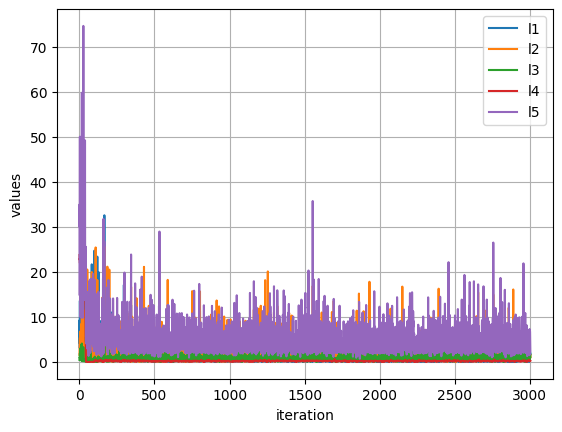

loss_df:              l1        l2        l3         l4         l5
0     1.367395  0.980132  0.152085  23.730448  14.958938
1     2.363721  1.876106  0.317599  23.212593  25.007498
2     1.585685  0.894766  0.182503  23.933580   9.968538
3     3.276263  1.593322  0.353615  23.416302  19.989471
4     3.389926  1.534344  0.450884  23.630550  14.974965
...        ...       ...       ...        ...        ...
3000  1.343834  5.127439  1.162110   0.239351   5.457346
3001  1.082393  1.357656  0.460561   0.216108   5.212574
3002  0.216672  1.688617  0.642906   0.186320   4.017214
3003  0.245126  0.508351  0.437368   0.288945   3.537140
3004  2.293972  2.877542  0.936050   0.277031   5.896699

[3005 rows x 5 columns]


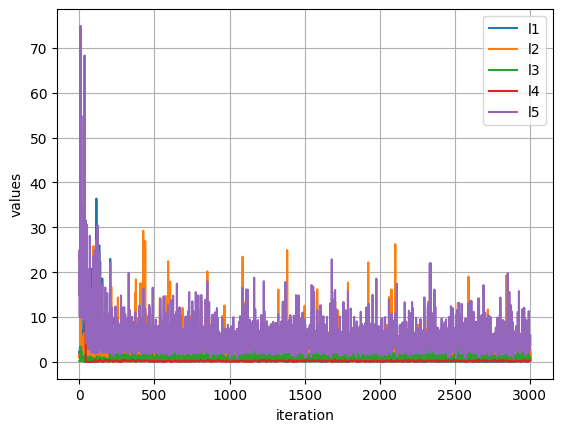

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
loss_dir = os.path.expanduser("~/Downloads")
for fname in ["/train_loss_latest.csv", "/val_loss_latest.csv"]:
    loss_df = pd.read_csv(loss_dir + fname, index_col=0)
    print("loss_df: ", loss_df)
    for col in loss_df.columns:
        if col == "l1" or col == "l2": #or col == "l5":
            plt.plot(loss_df[col], label=col)
    plt.xlabel("iteration")
    plt.ylabel("values")
    plt.legend()
    plt.grid(True)
    plt.show()